# Equilibrium Composition of a Char Bed Reactor

In this notebook we analyse the equilibrium gas composition from a
"char bed" reactor, where solid carbon reacts with a gas mixture over a
range of temperatures.

We:
- define the species of interest in the gas phase (CO, CO2, H2, H2O, CH4, N2),
- set the operating pressure and the temperature range for the analysis,
- use Cantera to enforce chemical equilibrium at each temperature,
- store the resulting equilibrium mole fractions and visualise their
  dependence on temperature.

This type of calculation is useful to understand how temperature affects
syngas composition in gasification or combustion systems.


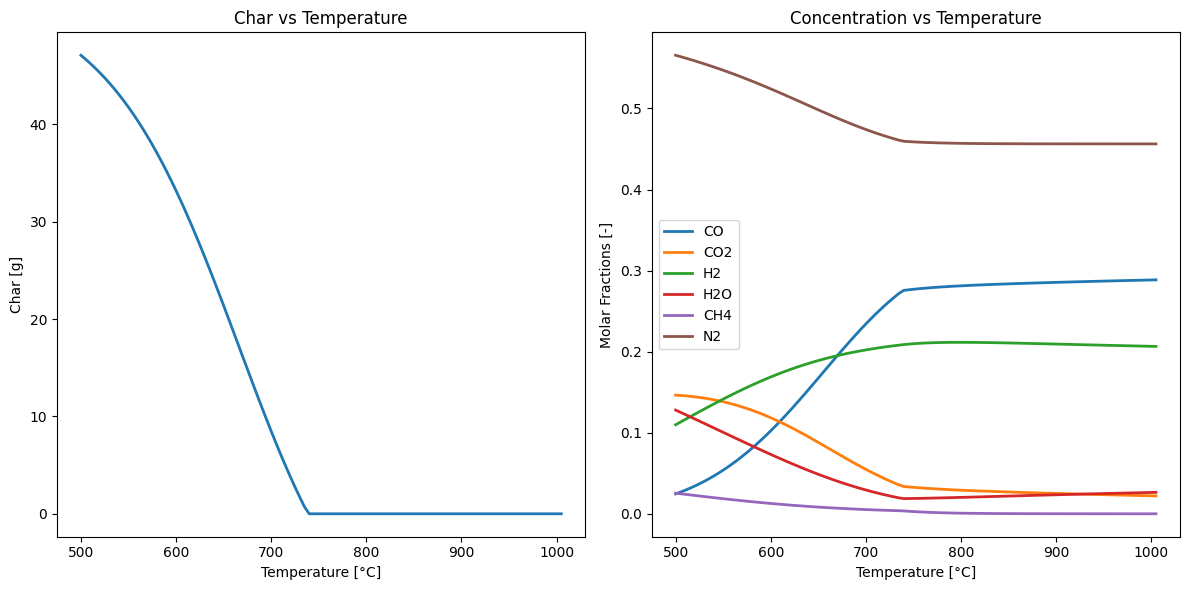

In [1]:
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------------------
# Input Parameters
# --------------------------------------------------------------------------
species_of_interest = ["CO", "CO2", "H2", "H2O", "CH4", "N2"]
pressure = ct.one_atm  # constant pressure [Pa]
Tmin = 500 + 273.15  # lower limit temperature range [K]
Tmax = 1000 + 273.15  # upper limit temperature range [K]
dT = 5  # temperature step [K]

gas_comp_0 = "CO2:5, H2:20, CO:25, CH4:2, N2:47, O2:1"  # inlet gas composition
char_mass_0 = 0  # initial mass of char in the reactor [kg]

# Import the gas and solid models
gas = ct.Solution("gri30.yaml")
graphite = ct.Solution("graphite.yaml")

# Molecular weight of graphite (char)
mw_char = graphite.mean_molecular_weight
molichar_0 = char_mass_0 / mw_char  # initial moles of char [kmol]
moligas_0 = 0.025  # initial moles of gas [kmol]

# Initialize vectors and matrices
T = np.arange(Tmin, Tmax + dT, dT)  # temperature array [K]
X = np.zeros((len(T), len(species_of_interest)))  # molar fractions [-]
Y = np.zeros((len(T), len(species_of_interest)))  # mass fractions [-]
moligas = np.zeros(len(T))  # moles of gas [kmol]
molichar = np.zeros(len(T))  # moles of char [kmol]
char_mass = np.zeros(len(T))  # mass of char [kg]
mw_gas = np.zeros(len(T))  # molecular weight of gas

# --------------------------------------------------------------------------
# Equilibrium Calculation
# --------------------------------------------------------------------------
for i, temp in enumerate(T):
    gas.TPX = temp, pressure, gas_comp_0
    graphite.TP = temp, pressure

    # Create a mixture with gas and graphite
    mix = ct.Mixture([(gas, moligas_0), (graphite, molichar_0)])
    mix.T = temp
    mix.P = pressure

    # Gas-solid equilibrium calculation
    mix.equilibrate("TP")

    # Update results
    moligas[i] = mix.phase_moles(0)  # moles of gas
    molichar[i] = mix.phase_moles(1)  # moles of char
    char_mass[i] = molichar[i] * mw_char  # mass of char [kg]

    # Use the equilibrated gas phase from the mixture
    gas_eq = mix.phase(0)
    X[i, :] = [gas_eq[m].X[0] for m in species_of_interest]  # molar fractions
    Y[i, :] = [gas_eq[m].Y[0] for m in species_of_interest]  # mass fractions
    mw_gas[i] = gas_eq.mean_molecular_weight  # molecular weight of gas

# --------------------------------------------------------------------------
# Plot Results
# --------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Plot char mass vs temperature
plt.subplot(1, 2, 1)
plt.plot(T - 273.15, char_mass * 1000, linewidth=2)
plt.title("Char vs Temperature")
plt.xlabel("Temperature [°C]")
plt.ylabel("Char [g]")

# Plot molar fractions vs temperature
plt.subplot(1, 2, 2)
for j, species in enumerate(species_of_interest):
    plt.plot(T - 273.15, X[:, j], linewidth=2, label=species)
plt.title("Concentration vs Temperature")
plt.xlabel("Temperature [°C]")
plt.ylabel("Molar Fractions [-]")
plt.legend()

plt.tight_layout()
plt.show()

### Instructor notes – mini-exercises

- At lower temperatures, the equilibrium is shifted towards CO2 and H2O;
  as T increases, CO and H2 become dominant above a few hundred
  degrees Celsius (exact range depends on pressure and composition).
- A reasonable gasifier operating window for good syngas quality is
  typically > 800–900 °C, where CO and H2 are high and tar formation is
  suppressed; you can connect this to practical design values for CHP
  gasifiers.
